In [2]:
!pip install keras-tuner -qq


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.5 MB/s eta 0:00:00


In [5]:
# Importar las librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import keras_tuner as kt

# Cargar el dataset MNIST
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

# Preprocesamiento de los datos
X_train_full = X_train_full.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Dividir el dataset de entrenamiento en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Aplanar las imágenes 28x28 en vectores de 784
X_train = X_train.reshape(-1, 784)
X_val = X_val.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

# Codificar las etiquetas en formato one-hot
y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)
y_test = to_categorical(y_test, 10)

# Definir la función de construcción del modelo para la búsqueda de hiperparámetros
def build_model(hp):
    model = Sequential()

    # Definir la primera capa oculta con un número variable de neuronas
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32),
                    activation='relu', input_shape=(784,)))

    # Añadir una capa de Dropout
    model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))

    # Capa de salida con 10 neuronas para las 10 clases de MNIST
    model.add(Dense(10, activation='softmax'))

    # Compilar el modelo
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [7]:
# 28 minutos con una T4 de Google Colab

# Configurar el tunning de hiperparámetros usando KerasTuner
tuner = kt.RandomSearch(
    build_model,                    # Función para construir el modelo
    objective='val_accuracy',        # Métrica a optimizar
    max_trials=10,                    # Número máximo de configuraciones que probar
    executions_per_trial=2,          # Ejecutar cada configuración 2 veces para más estabilidad
    directory='my_dir',              # Directorio para almacenar los resultados
    project_name='mnist_tuning')     # Nombre del proyecto

# Realizar la búsqueda de hiperparámetros
tuner.search(X_train, y_train, epochs=20, validation_data=(X_val, y_val))




Trial 10 Complete [00h 02m 44s]
val_accuracy: 0.9830833375453949

Best val_accuracy So Far: 0.9830833375453949
Total elapsed time: 00h 28m 05s


In [9]:
from tensorflow.keras.callbacks import EarlyStopping # Added this line to import the EarlyStopping class


# Obtener el mejor modelo encontrado
best_model = tuner.get_best_models(num_models=1)[0]

# Resumen del mejor modelo
best_model.summary()

# Entrenar el mejor modelo con EarlyStopping para evitar overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = best_model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping])
# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 480)                 │         376,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           4,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 381,610 (1.46 MB)

 Trainable params: 381,610 (1.46 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9989 - loss: 0.0037 - val_accuracy: 0.9831 - val_loss: 0.1000
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9992 - loss: 0.0025 - val_accuracy: 0.9819 - val_loss: 0.1043
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9992 - loss: 0.0025 - val_accuracy: 0.9820 - val_loss: 0.1060
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9991 - loss: 0.0028 - val_accuracy: 0.9834 - val_loss: 0.1005
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9995 - loss: 0.0016 - val_accuracy: 0.9826 - val_loss: 0.1047
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9996 - loss: 0.0015 - val_accuracy: 0.9834 - val_loss: 0.1030
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9777 - loss: 0.1130
Test accuracy: 0.9823


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.98      0.98       892
           6       0.99      0.98      0.98       958
           7       0.98      0.97      0.98      1028
           8       0.97      0.98      0.98       974
           9       0.98      0.97      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



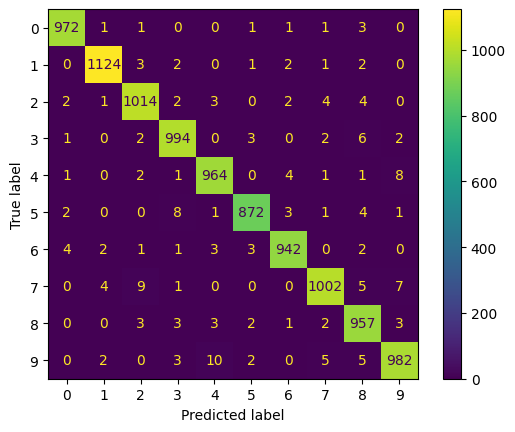

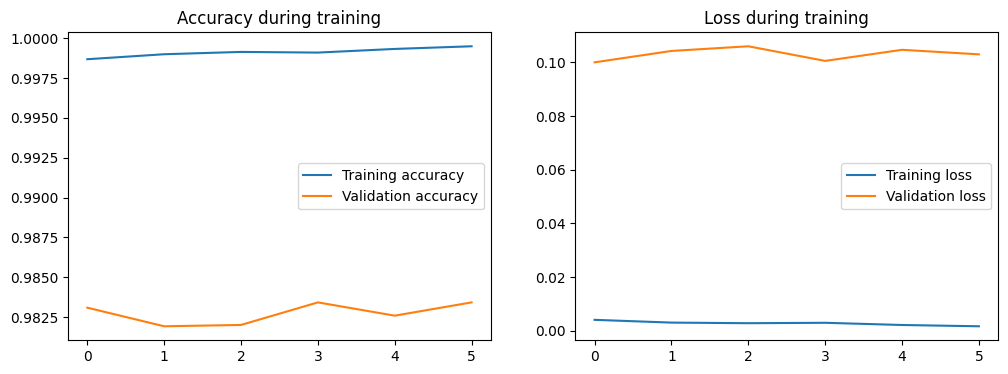

In [10]:
# Mostrar el reporte de clasificación
y_pred = np.argmax(best_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred))

# Mostrar la matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
plt.show()

# Graficar la precisión y pérdida durante el entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Accuracy during training')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss during training')
plt.legend()

plt.show()

# Como construir un buen modelo


In [25]:

# Obtener los mejores hiperparámetros
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hyperparameters.values)

build_model(best_hyperparameters).summary()

{'units': 480, 'dropout': 0.1, 'optimizer': 'rmsprop'}


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 480)                 │         376,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           4,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 381,610 (1.46 MB)

 Trainable params: 381,610 (1.46 MB)

 Non-trainable params: 0 (0.00 B)

Hagamos una sociedad de mentes, juntando modelos muy similares pero con variaciones de los hiperparametros

In [27]:
best_hyperparameters

# Vamos a guarar el modelo y ejecutarlo despues

In [12]:
# prompt: save the best model recently created so it can be later impordes as a tflite by fastAPI

# Guardar el modelo en formato SavedModel
best_model.save('mnist_model.keras')


In [14]:
# prompt: load the mnist_model.keras in a variable called loaded_model

from tensorflow.keras.models import load_model

# Cargar el modelo desde el archivo
loaded_model = load_model('mnist_model.keras')


Veamos de que es capaz un modelo de apenas 2MB y sin aumento de datos

In [70]:
def invert_colors(image_array):
    """Invierte los colores de la imagen: negro a blanco y viceversa."""
    return 1.0 - image_array  # Invertir los valores de 0 a 1


def predict_uploaded_image(model, pipeline=invert_colors):
    """
    Predice y visualiza una imagen cargada por el usuario.

    Args:
        model: El modelo de predicción cargado.
        pipeline: Una función que aplica una transformación personalizada a la imagen.
    """
    # Subir una imagen
    uploaded = files.upload()

    for fn in uploaded.keys():
        print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')

    # Cargar la imagen y preprocesarla
    image = Image.open(fn)
    image = image.convert('L')  # Convertir a escala de grises
    image = image.resize((28, 28))  # Redimensionar a 28x28 píxeles
    image_array = np.array(image)

    # Aplicar la función de pipeline (por ejemplo, invertir los colores)
    if pipeline != None:
      image_array = pipeline(image_array)

    image_array_img = image_array.astype('float32') / 255.0

    image_array = image_array.reshape(-1, 784)


    # Hacer la predicción con el modelo cargado
    prediction = model.predict(image_array)
    predicted_class = np.argmax(prediction)

    # Crear una figura con dos subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Primer subplot: Imagen con el número predicho
    axes[0].imshow(image_array_img, cmap='gray')
    font_prop = font_manager.FontProperties(family='serif', weight='bold', size=18)
    text = f"Predicción: {predicted_class}"
    axes[0].text(0.5, -0.1, text, fontsize=18, fontproperties=font_prop, color='blue', ha='center', transform=axes[0].transAxes)
    axes[0].set_title('Imagen Cargada (Transformada)')

    # Segundo subplot: Gráfico de barras de probabilidades de predicción
    axes[1].bar(range(10), prediction[0])  # Mostrar las probabilidades para cada clase
    axes[1].set_xticks(range(10))
    axes[1].set_xlabel('Clase')
    axes[1].set_ylabel('Probabilidad')
    axes[1].set_title('Probabilidades de Predicción')

    # Ajustar el layout y mostrar la figura
    plt.tight_layout()
    plt.show()

    # Mostrar la predicción en consola
    print(f"La imagen predicha es: {predicted_class}")
    return predicted_class


# El modelo tiene poco pre procesamiento

En pos de ser un modelo simple y ver como son los problemas en la vida real; podemos entrenar un modelo muy bien, pero si los datos se encuentran en formatos distintos como fondo blanco o fondo negro, el modelo tendra problemas.

En entornos profesionales
- Agregar proceamiento previo

**Observemos que sucede si no invertimos los colores**

Saving 1.png to 1.png
User uploaded file "1.png" with length 337 bytes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


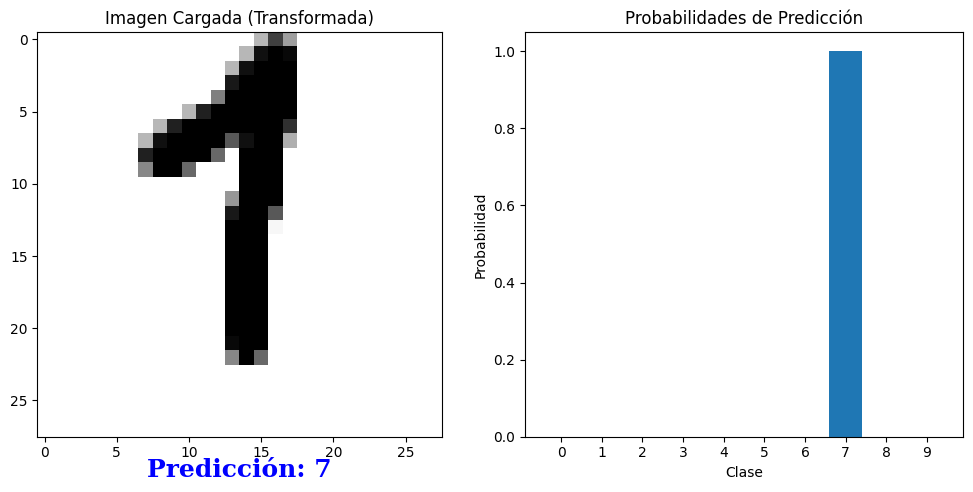

La imagen predicha es: 7


7

In [81]:
predict_uploaded_image(loaded_model, None)


Saving 1.png to 1 (1).png
User uploaded file "1 (1).png" with length 337 bytes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


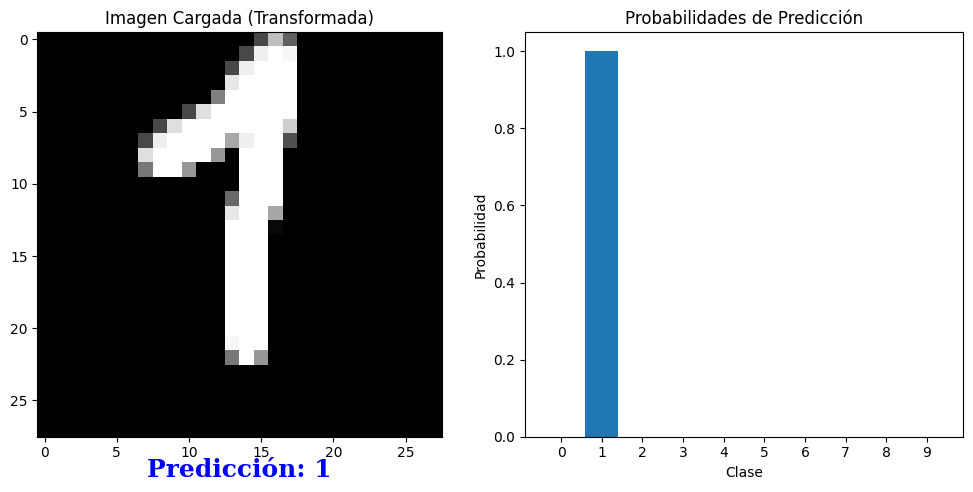

La imagen predicha es: 1


1

In [82]:
predict_uploaded_image(loaded_model, invert_colors) # teniendo la inversion aplicada

Saving 4_centered.png to 4_centered.png
User uploaded file "4_centered.png" with length 627 bytes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


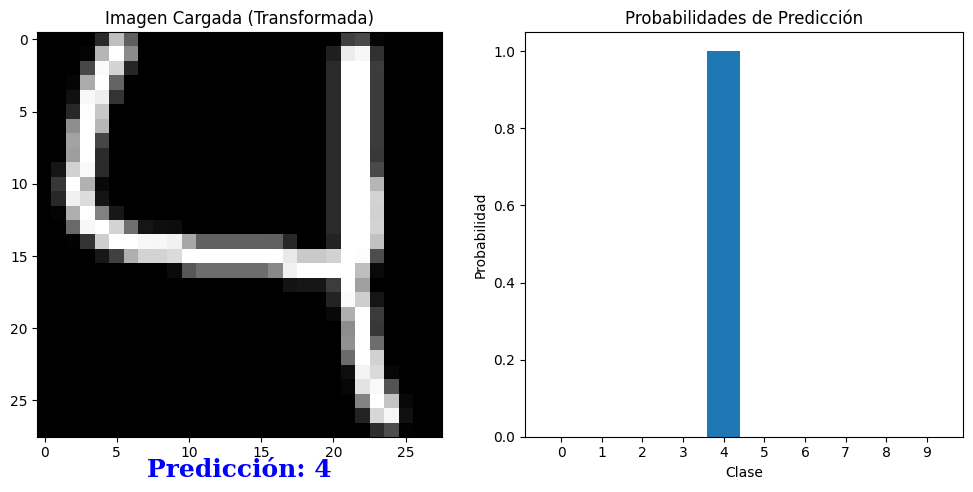

La imagen predicha es: 4


4

In [88]:
predict_uploaded_image(loaded_model)

Saving 9_centered.png to 9_centered.png
User uploaded file "9_centered.png" with length 545 bytes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


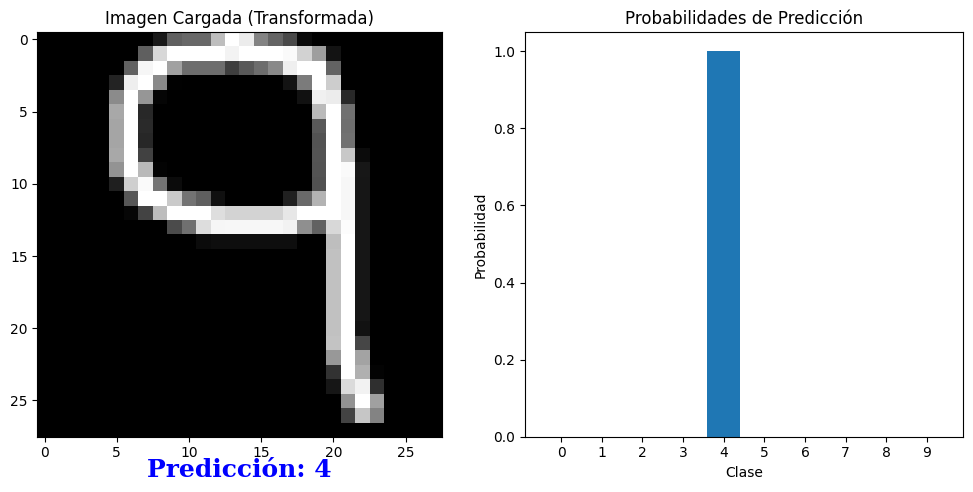

La imagen predicha es: 4


4

In [87]:
predict_uploaded_image(loaded_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


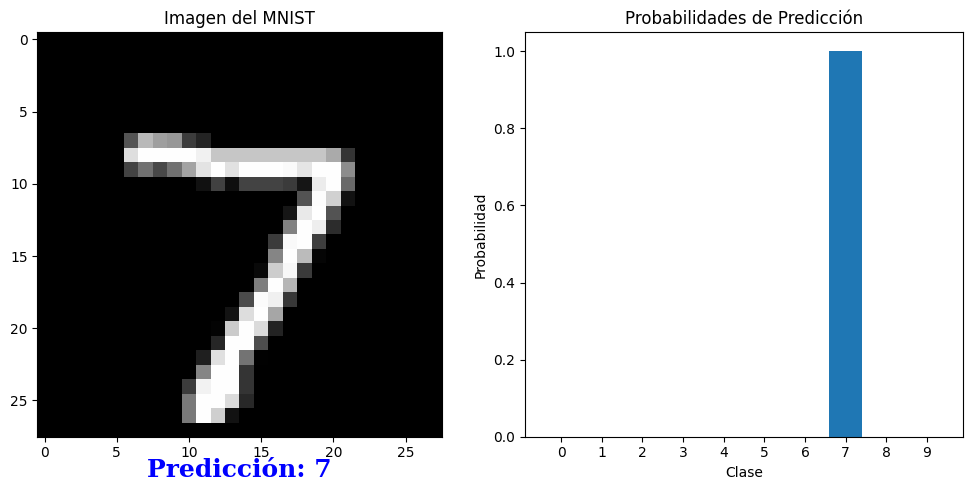

Clase verdadera: 7
La imagen predicha es: 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


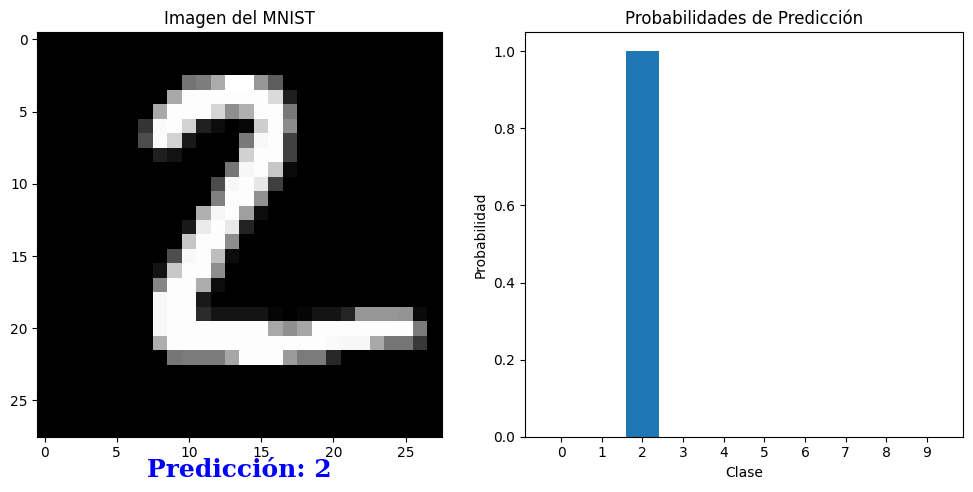

Clase verdadera: 2
La imagen predicha es: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


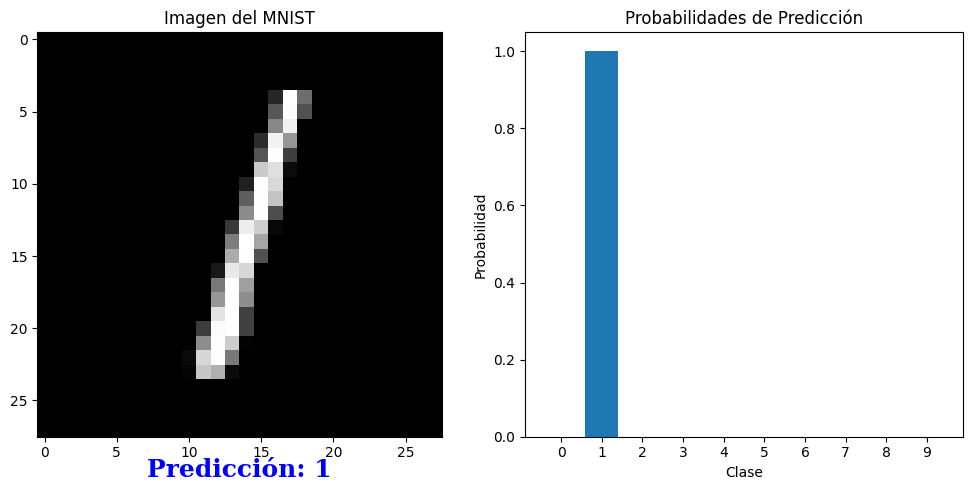

Clase verdadera: 1
La imagen predicha es: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


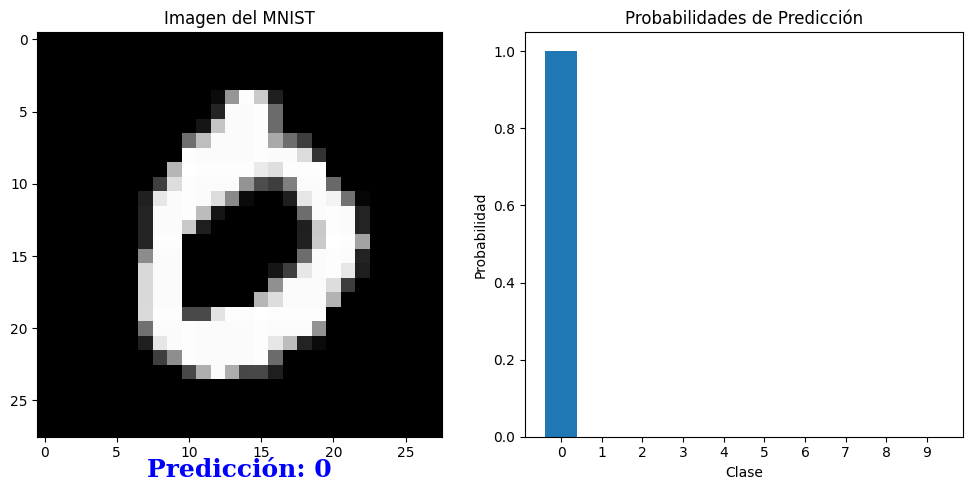

Clase verdadera: 0
La imagen predicha es: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


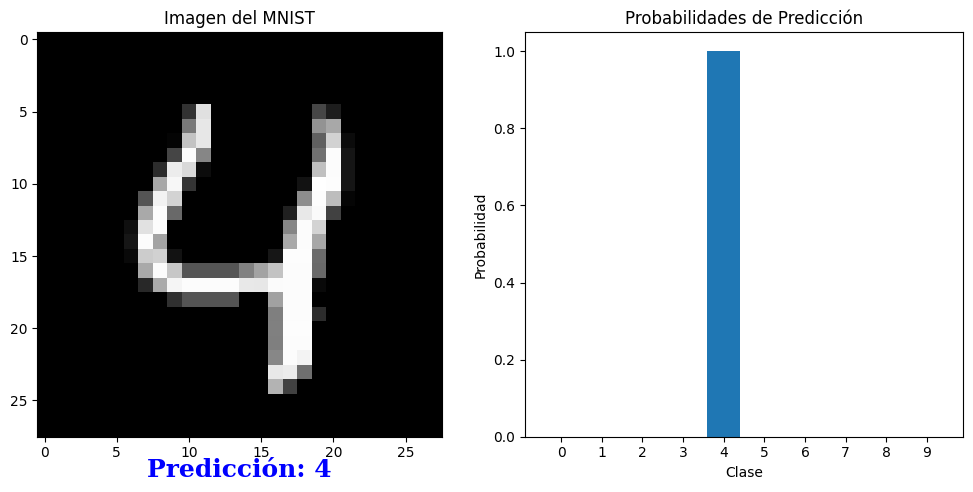

Clase verdadera: 4
La imagen predicha es: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


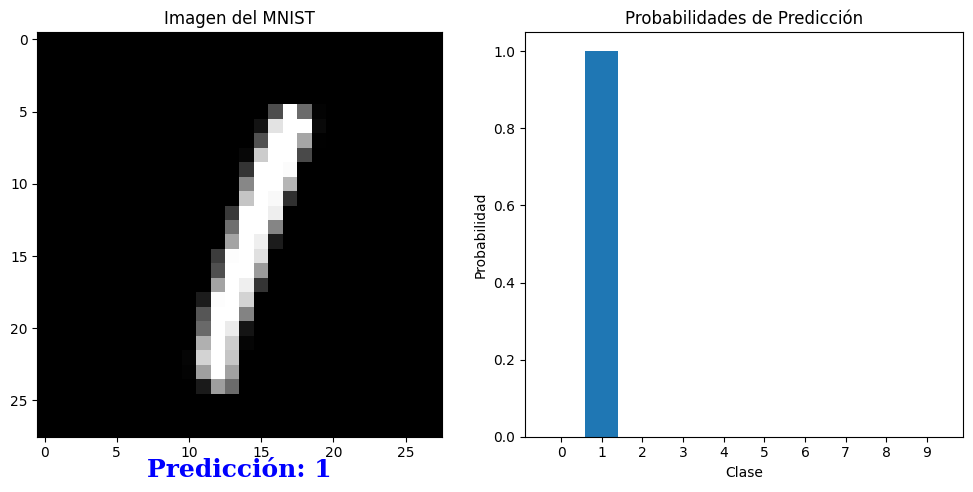

Clase verdadera: 1
La imagen predicha es: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


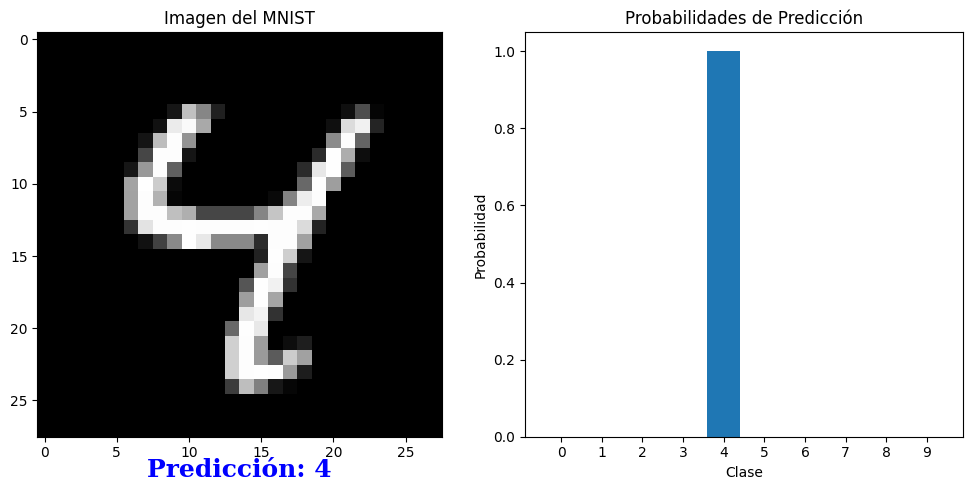

Clase verdadera: 4
La imagen predicha es: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


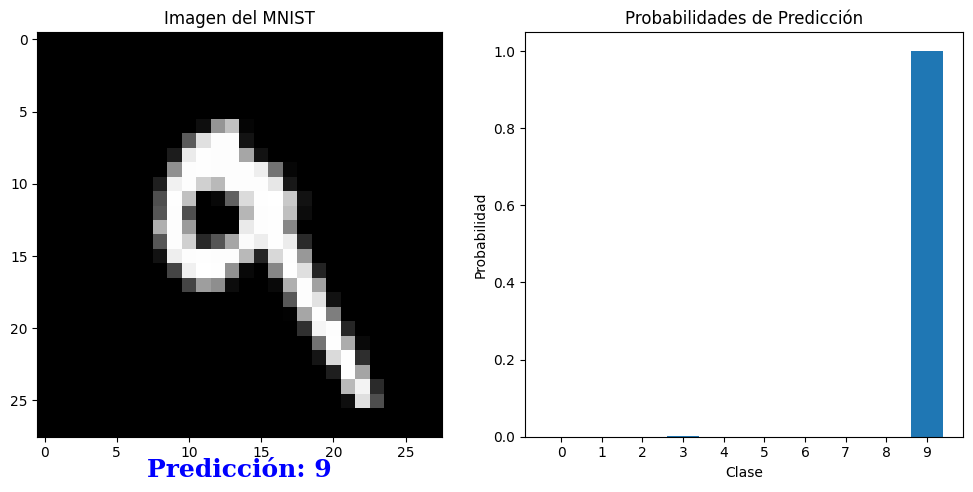

Clase verdadera: 9
La imagen predicha es: 9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


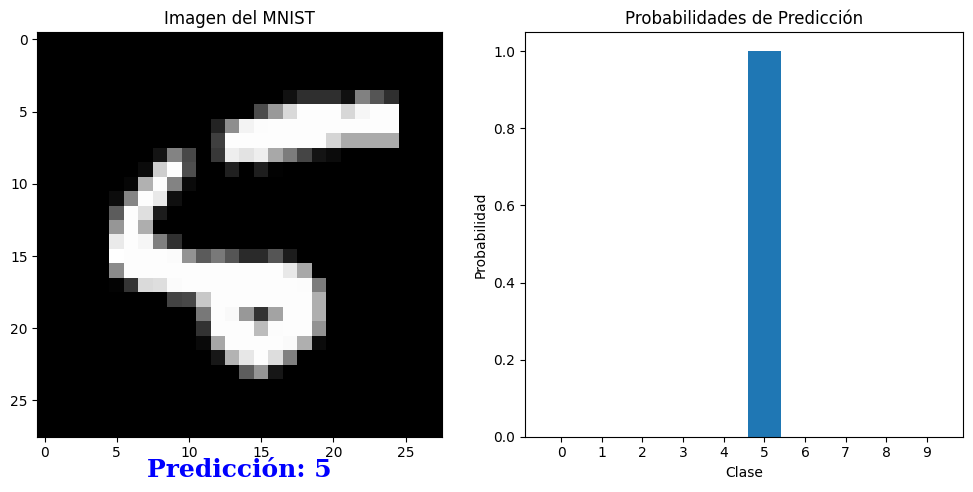

Clase verdadera: 5
La imagen predicha es: 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


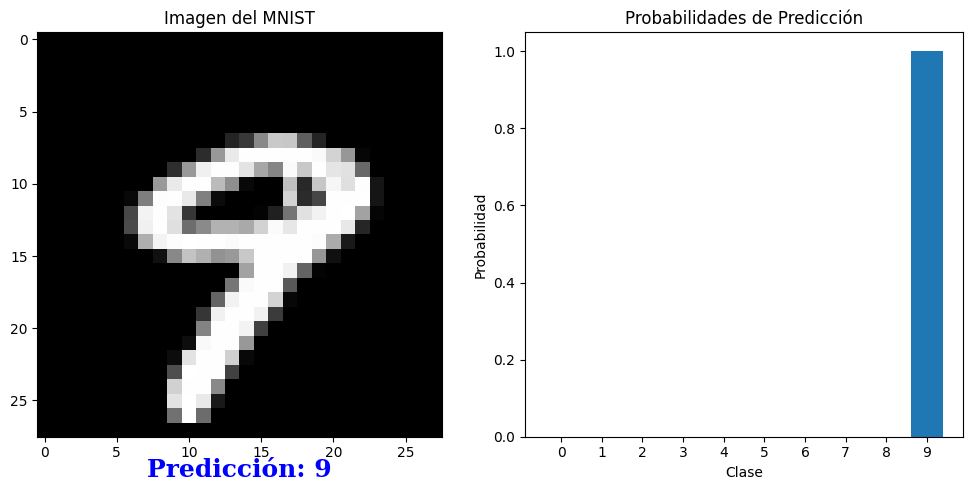

Clase verdadera: 9
La imagen predicha es: 9


In [86]:
for idx in range(10):
  predict_mnist_sample(loaded_model, X_test, y_test, sample_index=idx)


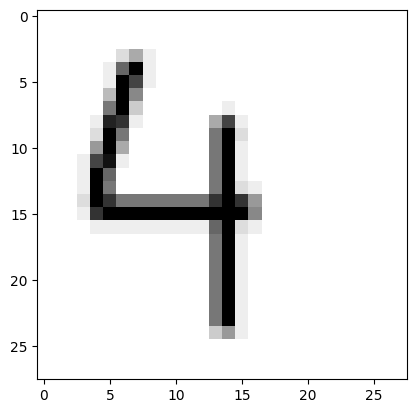

In [93]:
plt.imshow(image_array, cmap='gray')
plt.show()

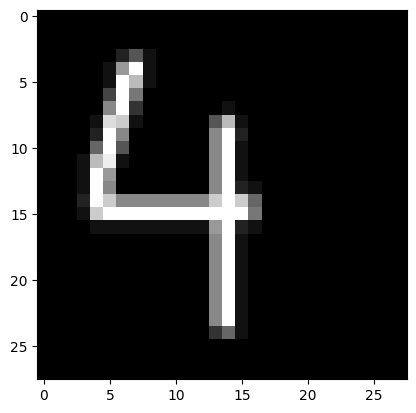

In [94]:
plt.imshow(1-image_array, cmap='gray')
plt.show()